In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
import h5py
import multigrate

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = 'retina'

# Load the datasets

In [4]:
scrna = sc.read_h5ad('../data/10xpbmc10k-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 10000 × 3999
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [5]:
scatac = sc.read_h5ad('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40086
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    layers: 'binary'
    obsp: 'connectivities', 'distances'

## Configure and train the model

In [6]:
model = multigrate.models.MultiVAE(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    pair_groups=[[0], [0]],
    z_dim=20,
    h_dim=128,
    hiddens=[[], []],
    output_activations=['linear', 'linear'],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-4,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [7]:
model.train(
    n_iters=20000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
    kl_anneal_iters=10000,
    validate_every=2000,
    verbose=1
)

/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


 |████████████████████| 100.0% iter=20000/20000, time=24.50(s), loss=0.2124, recon=0.2042, kl=44.0724, integ=0.3780, cycle=0.2072, val_loss=0.2081, val_recon=0.2006, val_kl=44.5215, val_integ=0.3025, val_cycle=0.2024

### Plot training history

In [8]:
model.history

,iteration,train_loss,train_recon,train_kl,train_integ,train_cycle,val_loss,val_recon,val_kl,val_integ,val_cycle
0,1000,0.294072,0.242301,43.129822,5.149258,0.247758,0.242442,0.209299,53.062859,3.261261,0.219925
1,2000,0.234187,0.210786,64.625259,2.223559,0.215903,0.222227,0.205337,64.134140,1.560722,0.212810
2,3000,0.225813,0.210869,71.479202,1.308522,0.214629,0.215072,0.204340,72.135498,0.856835,0.212401
3,4000,0.217564,0.209339,77.647324,0.527649,0.214630,0.210981,0.203384,74.296516,0.462511,0.208809
4,5000,0.213363,0.205388,73.194557,0.460879,0.209073,0.209853,0.202888,70.514725,0.343990,0.207986
5,6000,0.216141,0.208921,67.916962,0.328376,0.214331,0.208930,0.202622,64.341034,0.244741,0.206178
6,7000,0.215381,0.208149,63.596458,0.303842,0.211826,0.208641,0.202545,59.269428,0.194696,0.205140
7,8000,0.216085,0.208720,57.472908,0.288256,0.213228,0.208568,0.202254,54.789787,0.193106,0.204804
8,9000,0.212598,0.204889,53.881662,0.307928,0.207844,0.208697,0.201825,51.501915,0.223687,0.203712
9,10000,0.216422,0.208041,49.507620,0.353105,0.211421,0.209102,0.201809,47.449818,0.254854,0.203680


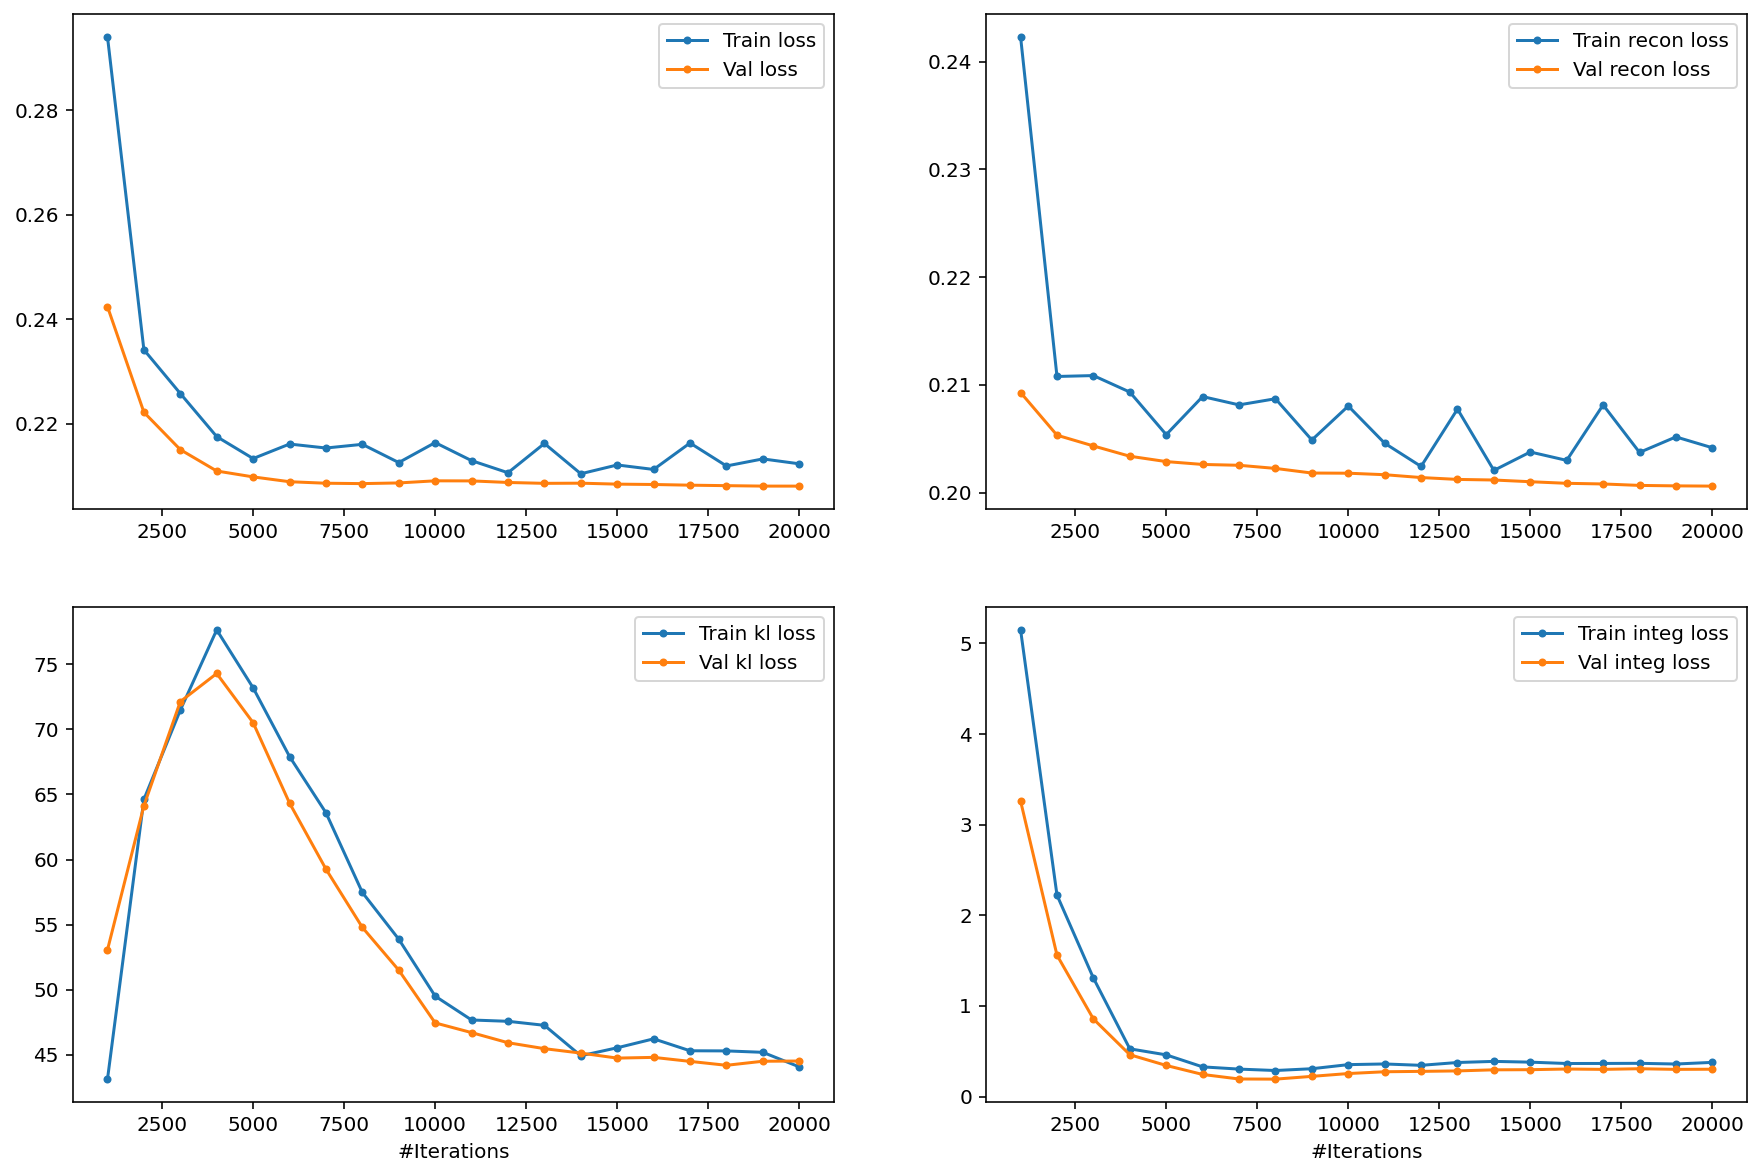

In [9]:
plt.figure(figsize=(15, 10));
plt.subplot(221);
plt.plot(model.history['iteration'], model.history['train_loss'], '.-', label='Train loss');
plt.plot(model.history['iteration'], model.history['val_loss'], '.-', label='Val loss');
plt.legend();

plt.subplot(222);
plt.plot(model.history['iteration'], model.history['train_recon'], '.-', label='Train recon loss');
plt.plot(model.history['iteration'], model.history['val_recon'], '.-', label='Val recon loss');
plt.legend();

plt.subplot(223);
plt.plot(model.history['iteration'], model.history['train_kl'], '.-', label='Train kl loss');
plt.plot(model.history['iteration'], model.history['val_kl'], '.-', label='Val kl loss');
plt.xlabel('#Iterations');
plt.legend();

plt.subplot(224);
plt.plot(model.history['iteration'], model.history['train_integ'], '.-', label='Train integ loss');
plt.plot(model.history['iteration'], model.history['val_integ'], '.-', label='Val integ loss');
plt.xlabel('#Iterations');
plt.legend();

## Validation

### UMAP plot of the latent space

In [10]:
z = model.predict(
    adatas=[[scrna], [scatac]],
    names=[['scRNA-seq'], ['scATAC-seq']],
    batch_size=64,
)
z

/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 20000 × 20
    obs: 'modality', 'cell_type', 'batch'

In [11]:
sc.pp.neighbors(z)
sc.tl.umap(z)

/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'modality' as categorical
... storing 'cell_type' as categorical


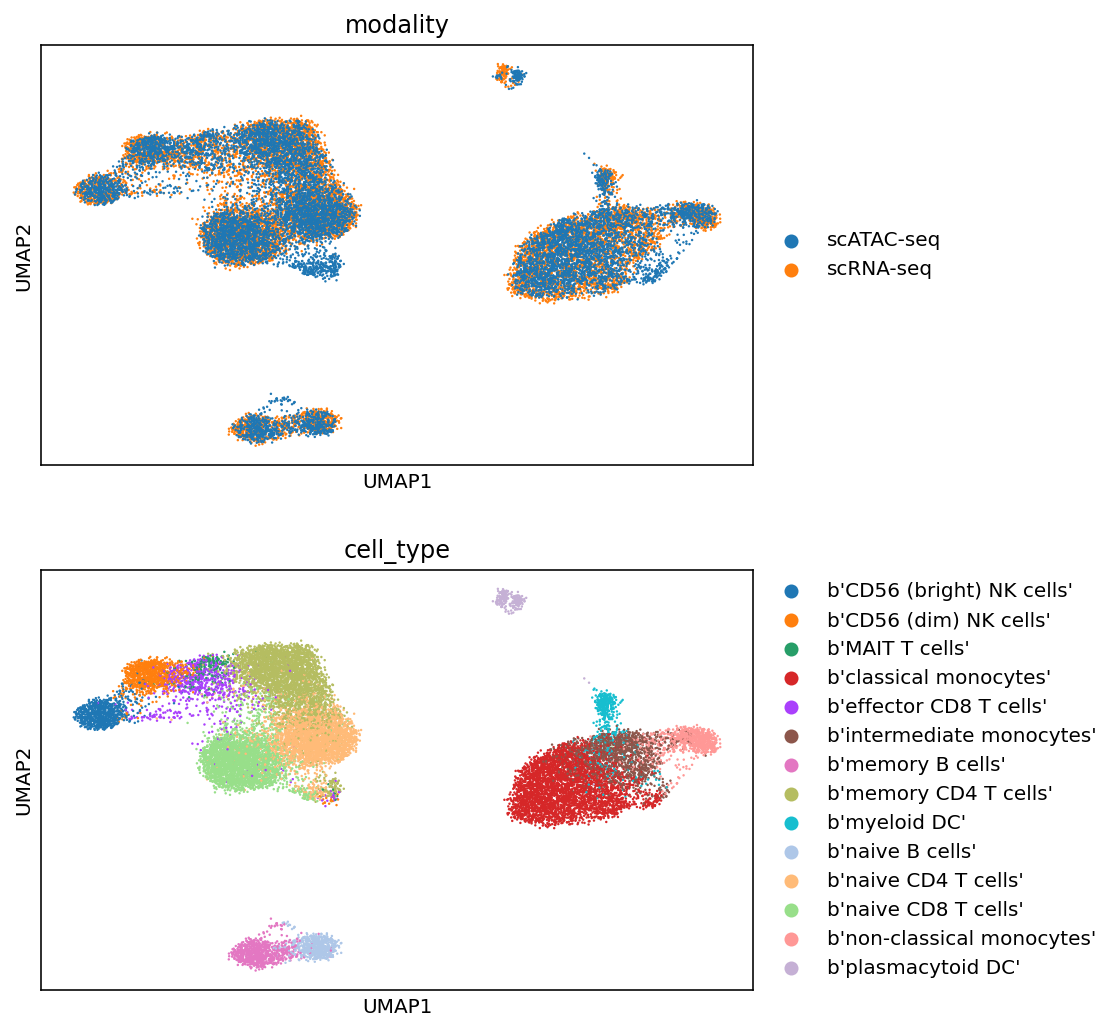

In [12]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

### Metrics

In [13]:
sc.pp.pca(z)
metrics = multigrate.metrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type'
)
metrics

Clustering...
ASW label/batch...


/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be remov

PCR batch...
Graph connectivity...
ASW label...


/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/multigrate/lib/python3.7/site-packages/multigrate-0.1.0-py3.7.egg/multigrate/metrics.py:548: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  _,labs = connected_components(adata_post_sub.uns['neighbors']['connectivities'], connection='strong')


NMI cluster/label...
ARI cluster/label...
Isolated label silhouette...


,score
ASW_label/batch,0.968942
PCR_batch,0.000000
graph_conn,0.987446
ASW_label,0.549718
NMI_cluster/label,0.784564
ARI_cluster/label,0.707540
isolated_label_silhouette,0.549879
